## Import Data

In [27]:
import pandas as pd

# Load data
generation_data = pd.read_csv('Plant_2_Generation_Data.csv')
weather_data = pd.read_csv('Plant_2_Weather_Sensor_Data.csv')

# Display Dataset head
print(generation_data.head())
print(weather_data.head())

             DATE_TIME  PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  \
0  2020-05-15 00:00:00   4136001  4UPUqMRk7TRMgml       0.0       0.0   
1  2020-05-15 00:00:00   4136001  81aHJ1q11NBPMrL       0.0       0.0   
2  2020-05-15 00:00:00   4136001  9kRcWv60rDACzjR       0.0       0.0   
3  2020-05-15 00:00:00   4136001  Et9kgGMDl729KT4       0.0       0.0   
4  2020-05-15 00:00:00   4136001  IQ2d7wF4YD8zU1Q       0.0       0.0   

   DAILY_YIELD   TOTAL_YIELD  
0  9425.000000  2.429011e+06  
1     0.000000  1.215279e+09  
2  3075.333333  2.247720e+09  
3   269.933333  1.704250e+06  
4  3177.000000  1.994153e+07  
             DATE_TIME  PLANT_ID       SOURCE_KEY  AMBIENT_TEMPERATURE  \
0  2020-05-15 00:00:00   4136001  iq8k7ZNt4Mwm3w0            27.004764   
1  2020-05-15 00:15:00   4136001  iq8k7ZNt4Mwm3w0            26.880811   
2  2020-05-15 00:30:00   4136001  iq8k7ZNt4Mwm3w0            26.682055   
3  2020-05-15 00:45:00   4136001  iq8k7ZNt4Mwm3w0            26.500589   
4  20

## Get Basic Info about Dataset

In [28]:
# Display basic info
print(generation_data.info())
print(weather_data.info())

# Describe datasets
print(generation_data.describe())
print(weather_data.describe())

# Check for missing values
print(generation_data.isnull().sum())
print(weather_data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67698 entries, 0 to 67697
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    67698 non-null  object 
 1   PLANT_ID     67698 non-null  int64  
 2   SOURCE_KEY   67698 non-null  object 
 3   DC_POWER     67698 non-null  float64
 4   AC_POWER     67698 non-null  float64
 5   DAILY_YIELD  67698 non-null  float64
 6   TOTAL_YIELD  67698 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 3.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3259 entries, 0 to 3258
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE_TIME            3259 non-null   object 
 1   PLANT_ID             3259 non-null   int64  
 2   SOURCE_KEY           3259 non-null   object 
 3   AMBIENT_TEMPERATURE  3259 non-null   float64
 4   MODULE_TEMPERATURE   3259 non-null  

## Preprocess Data

In [29]:
# Drop missing values
generation_data.dropna(inplace=True)
weather_data.dropna(inplace=True)

# Drop duplicates
generation_data.drop_duplicates(inplace=True)
weather_data.drop_duplicates(inplace=True)

# Convert DATE_TIME to datetime
generation_data['DATE_TIME'] = pd.to_datetime(generation_data['DATE_TIME'])
weather_data['DATE_TIME'] = pd.to_datetime(weather_data['DATE_TIME'])

## Visualize Weather Parameters and DC Ouptut

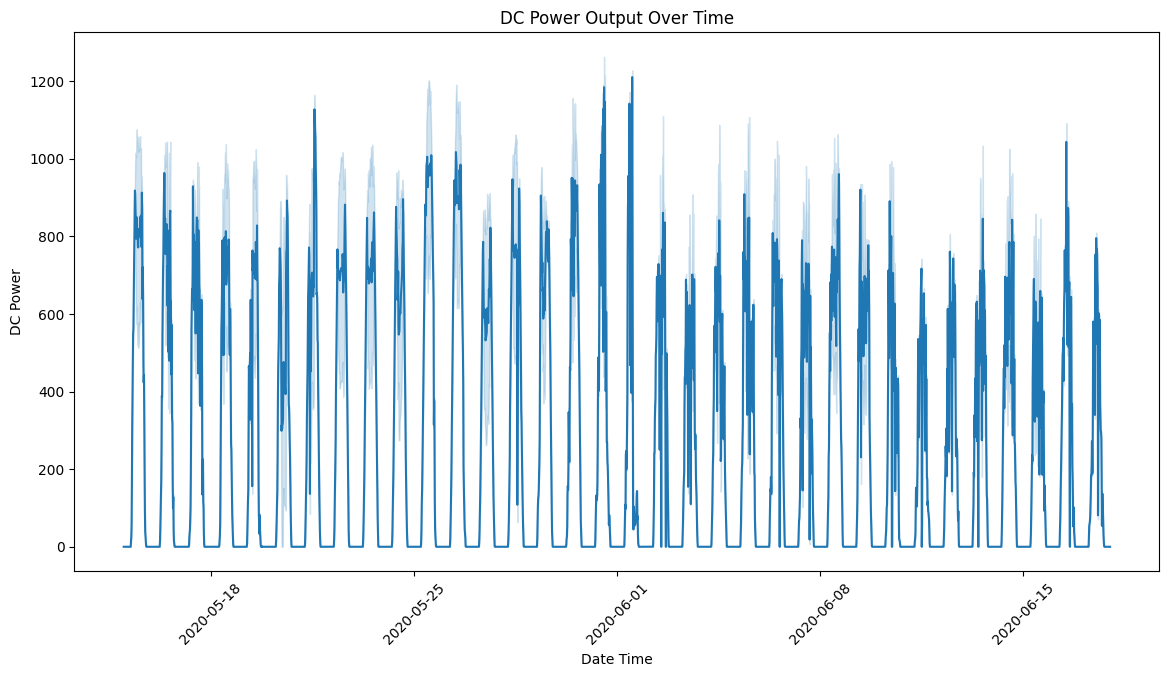

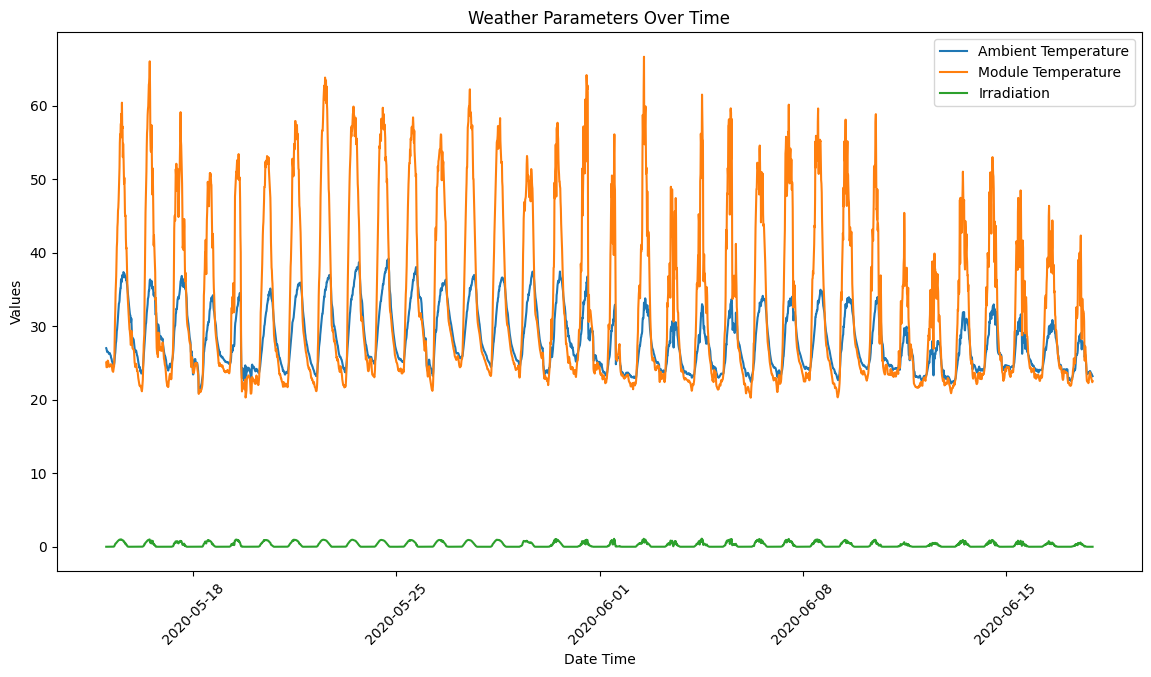

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Plotting power output over time
plt.figure(figsize=(14, 7))
sns.lineplot(data=generation_data, x='DATE_TIME', y='DC_POWER')
plt.title('DC Power Output Over Time')
plt.xlabel('Date Time')
plt.ylabel('DC Power')
plt.xticks(rotation=45)

# Set date format on x-axis
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.show()

# Plotting weather parameters over time
plt.figure(figsize=(14, 7))
sns.lineplot(data=weather_data, x='DATE_TIME', y='AMBIENT_TEMPERATURE', label='Ambient Temperature')
sns.lineplot(data=weather_data, x='DATE_TIME', y='MODULE_TEMPERATURE', label='Module Temperature')
sns.lineplot(data=weather_data, x='DATE_TIME', y='IRRADIATION', label='Irradiation')
plt.title('Weather Parameters Over Time')
plt.xlabel('Date Time')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend()

# Set date format on x-axis
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.show()


## Feature Engineering Setup

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Merge datasets on DATE_TIME
merged_data = pd.merge(generation_data, weather_data, on='DATE_TIME')

# Feature Engineering before aggregation
merged_data['HOUR'] = merged_data['DATE_TIME'].dt.hour
merged_data['DAY'] = merged_data['DATE_TIME'].dt.day
merged_data['DAY_OF_WEEK'] = merged_data['DATE_TIME'].dt.dayofweek
merged_data['IS_WEEKEND'] = merged_data['DAY_OF_WEEK'] >= 5

numeric_columns = merged_data.select_dtypes(include=['float64', 'int64']).columns
daily_data = merged_data.groupby(merged_data['DATE_TIME'].dt.date)[numeric_columns].mean().reset_index()

# Recreate time-based features in the aggregated data
daily_data['DATE'] = pd.to_datetime(daily_data['DATE_TIME'])
daily_data['HOUR'] = daily_data['DATE'].dt.hour
daily_data['DAY'] = daily_data['DATE'].dt.day
daily_data['DAY_OF_WEEK'] = daily_data['DATE'].dt.dayofweek
daily_data['IS_WEEKEND'] = daily_data['DAY_OF_WEEK'] >= 5

# Selecting features
X = daily_data[['HOUR', 'DAY', 'DAY_OF_WEEK', 'IS_WEEKEND', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']]
y = daily_data['DC_POWER']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Model 1 with Random Forest

In [32]:
# Model Training
rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_

y_pred_rf = best_rf.predict(X_test)

rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
print(f'Random Forest RMSE: {rmse_rf}')

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Random Forest RMSE: 24.76728234847199


## Model 2 XG-Boost

In [22]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# Define model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Perform Random Search with Cross-Validation
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, n_iter=50, cv=3, n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_train, y_train)

# Get best model
best_xgb = random_search.best_estimator_

# Predict on the test set
y_pred_xgb = best_xgb.predict(X_test)

# Eval model
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
print(f'XGBoost RMSE: {rmse_xgb}')


Fitting 3 folds for each of 50 candidates, totalling 150 fits
XGBoost RMSE: 23.480783974568933


## Model 3 Linear Regression

In [23]:
# Init and train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict test set
y_pred = model.predict(X_test)

# Eval model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Linear Regression RMSE: {rmse}')

Linear Regression RMSE: 22.543291628755725


## Model 4 Ridge Regression (Best Performer)

In [24]:
from sklearn.linear_model import Ridge

# Init and train Ridge Regression model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

# Predict on test set
y_pred_ridge = ridge_model.predict(X_test)

# Eval model
rmse_ridge = mean_squared_error(y_test, y_pred_ridge, squared=False)
print(f'Ridge Regression RMSE: {rmse_ridge}')


Ridge Regression RMSE: 21.774389552928394


## Analyze Feature Importance

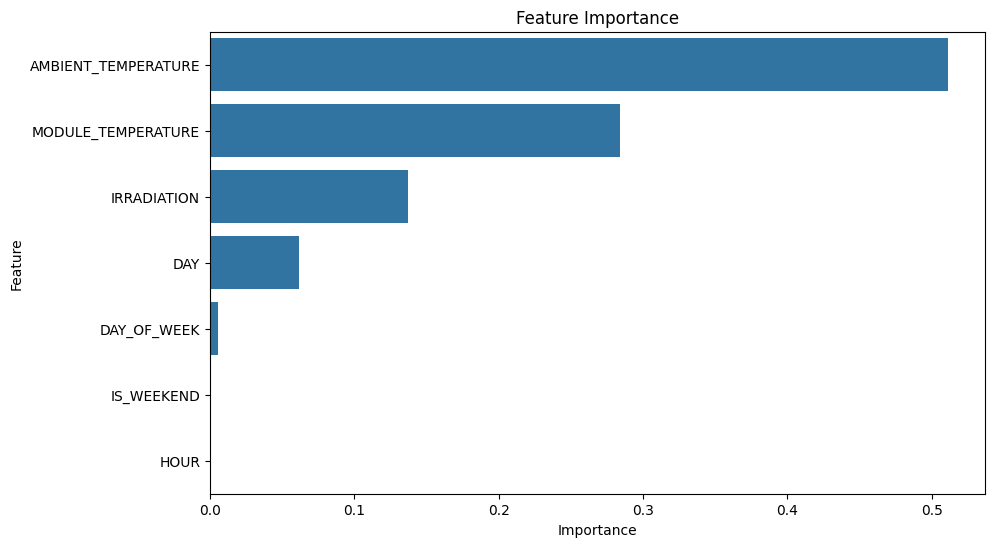

In [25]:
feature_importances = best_rf.feature_importances_
features = ['HOUR', 'DAY', 'DAY_OF_WEEK', 'IS_WEEKEND', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance')
plt.show()

## Answering Assesment Questions and Visualizing Model Perfomance

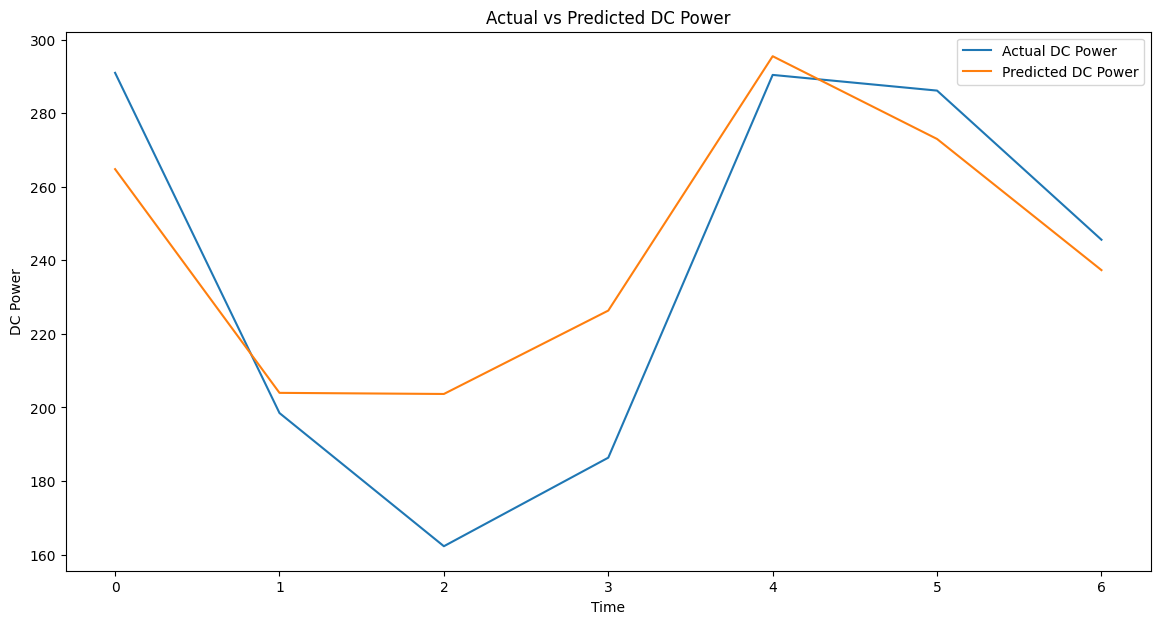

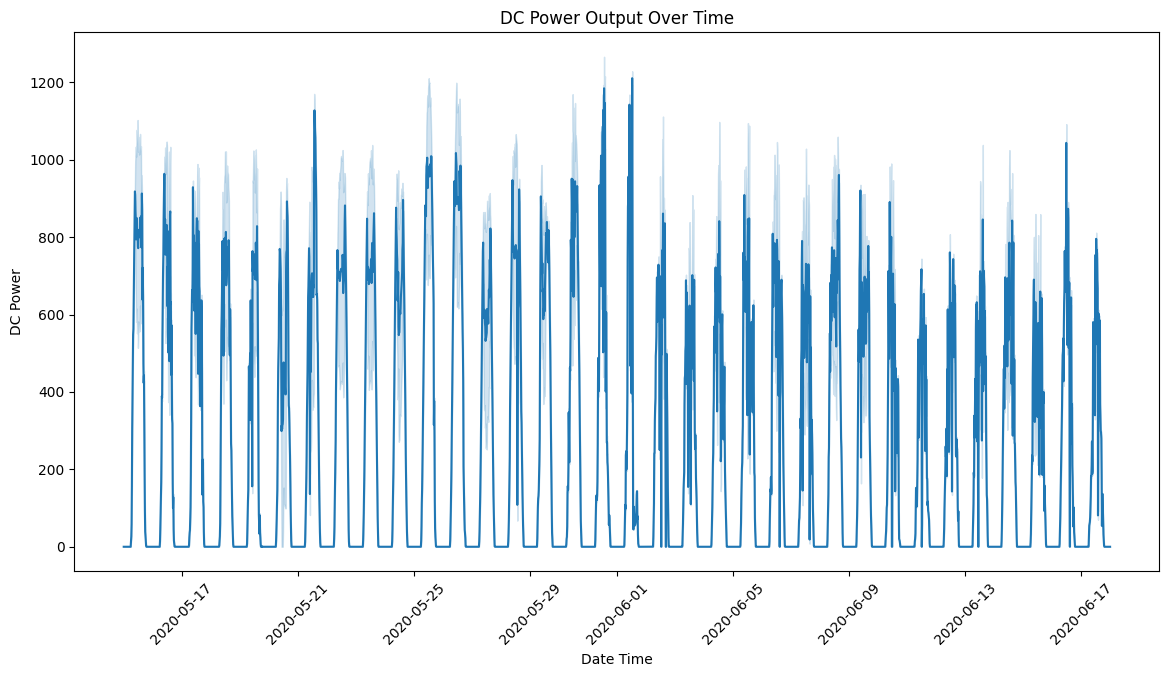

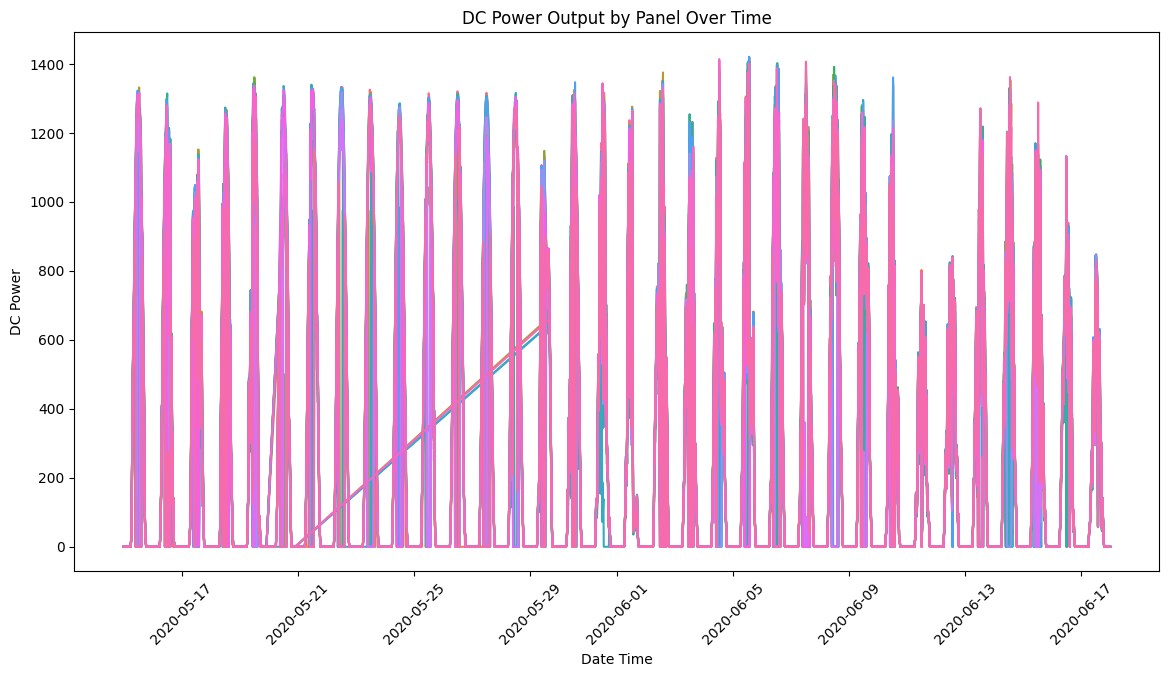

In [30]:
# Plotting actual vs. predicted power generation
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual DC Power')
plt.plot(y_pred_rf, label='Predicted DC Power')
plt.title('Actual vs Predicted DC Power')
plt.xlabel('Time')
plt.ylabel('DC Power')
plt.legend()
plt.show()


# Visualizing power generation to identify sudden drops
plt.figure(figsize=(14, 7))
sns.lineplot(data=merged_data, x='DATE_TIME', y='DC_POWER')
plt.title('DC Power Output Over Time')
plt.xlabel('Date Time')
plt.ylabel('DC Power')
plt.xticks(rotation=45)
plt.show()



# Plotting performance of different panels over time
plt.figure(figsize=(14, 7))
sns.lineplot(data=generation_data, x='DATE_TIME', y='DC_POWER', hue='SOURCE_KEY', legend=False)
plt.title('DC Power Output by Panel Over Time')
plt.xlabel('Date Time')
plt.ylabel('DC Power')
plt.xticks(rotation=45)
plt.show()